## **Traffic Optimization Using a Variational Quantum Eigensolver**
Carla Silva and Inês Dutra, Faculty of Sciences, University of Porto, Portugal (October 2019) exploring the IBM Q Experience Qiskit Aqua: Experimenting with Max-Cut problem with variational quantum eigensolver 

In [0]:
!pip install qiskit

In [0]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

## (a) generating an artificial network simulating a small network in a city with random traffic flow weights

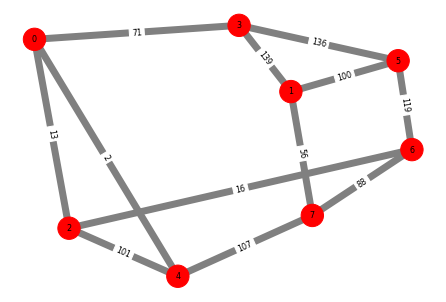

In [11]:
# Generating a graph 
from networkx import random_regular_graph
import random
G = random_regular_graph(3,8)
for (u,v,w) in G.edges(data=True):
    w['weight'] = random.randint(0,150)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_color = colors, edge_color = 'gray' , width = 7, node_size=500, font_size = 8, font_color='black')  #with_labels=true is to show the node number in the output graph
edge_labels = dict([((u, v,), d['weight']) for (u, v, d) in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, label_pos = 0.5, font_size = 8) #prints weight on all the edges
plt.show()


In [12]:
# Normalization
norm = []
for (u,v,d) in G.edges(data=True):
	norm.append(d['weight'])
  
norm = np.array(norm)
for (u,v,d) in G.edges(data=True):
  d['weight'] = (d['weight'] - norm.min()) / (norm.max() - norm.min())
  
# Computing the weight matrix from the random graph
n = len(G)
w = np.zeros([n,n])
for (u,v,d) in G.edges(data=True):
  w[u,v] = round(d['weight'],2)
  w[v,u] = round(d['weight'],2)
print(w)

[[0.   0.   0.08 0.5  0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.72 0.   0.39]
 [0.08 0.   0.   0.   0.72 0.   0.1  0.  ]
 [0.5  1.   0.   0.   0.   0.98 0.   0.  ]
 [0.   0.   0.72 0.   0.   0.   0.   0.77]
 [0.   0.72 0.   0.98 0.   0.   0.85 0.  ]
 [0.   0.   0.1  0.   0.   0.85 0.   0.63]
 [0.   0.39 0.   0.   0.77 0.   0.63 0.  ]]


energy: -1.869208984375
time: 184.62767481803894
max-cut objective: -5.239208984375
solution: [0 0 1 1 0 0 1 1]
solution objective: 5.29


{(2, 0): Text(-0.021375766347197622, -0.5934743170271828, '0.08'),
 (2, 6): Text(-0.4702281281800107, -0.2180084028772832, '0.1'),
 (3, 0): Text(0.7902291968603699, -0.30802686995336354, '0.5'),
 (3, 1): Text(0.6325222102091972, 0.2746431201845615, '1.0'),
 (3, 5): Text(0.610036174897292, 0.0832559055589994, '0.98'),
 (4, 0): Text(-0.11864787798029647, -0.3212086791592346, '0.0'),
 (4, 2): Text(-0.9027278883669012, -0.2485380656657518, '0.72'),
 (4, 7): Text(-0.7448053041055158, 0.21822743770102446, '0.77'),
 (5, 1): Text(0.42480423542515655, 0.3078078351296223, '0.72'),
 (6, 5): Text(0.1336588602435161, 0.10060375914159687, '0.85'),
 (7, 1): Text(-0.021160168736984897, 0.45596117647751844, '0.39'),
 (7, 6): Text(-0.3123055439186254, 0.24875710048949304, '0.63')}

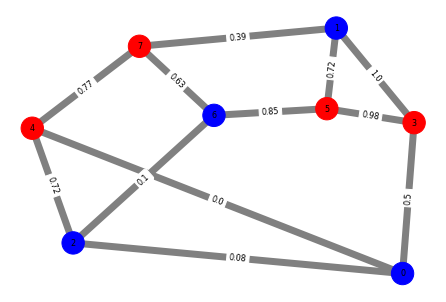

In [13]:
# Mapping to the Ising problem
qubitOp, offset = max_cut.get_max_cut_qubitops(w)
algo_input = EnergyInput(qubitOp)

# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""declarative approach, update the param from the previous cell.
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params, algo_input)
"""

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_color = colors, edge_color = 'gray' ,width = 7, node_size=500, font_size = 8, font_color='black')  
edge_labels = dict([((u, v,), round(d['weight'],2)) for (u, v, d) in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, with_labels = False, edge_labels = edge_labels, label_pos = 0.5, font_size = 8) 


In [0]:
!pip install osmnx


In [0]:
!apt-get install -qq curl g++ make

In [0]:
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz

In [0]:
import os
os.chdir('spatialindex-src-1.8.5')

In [0]:
!./configure

In [0]:
!make

In [0]:
!make install

In [0]:
!pip install rtree

In [0]:
!ldconfig

In [0]:
!sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config

In [0]:
!pip install pygraphviz

## (b) generating a real-world city network considering the length of the road links as the weights

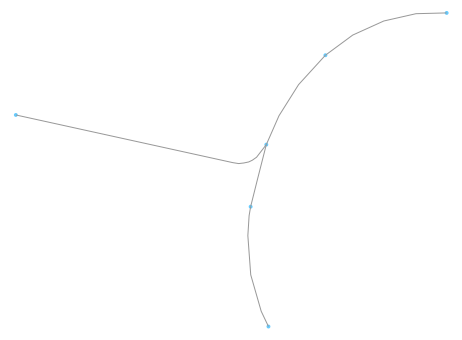

In [25]:
import osmnx as ox
# Boavista, Porto, Portugal
location_point = (41.158132, -8.629149) 
G = ox.graph_from_point(location_point, distance=300, distance_type='network', network_type='drive')
ox.plot_graph(G)
G = nx.convert_node_labels_to_integers(G)

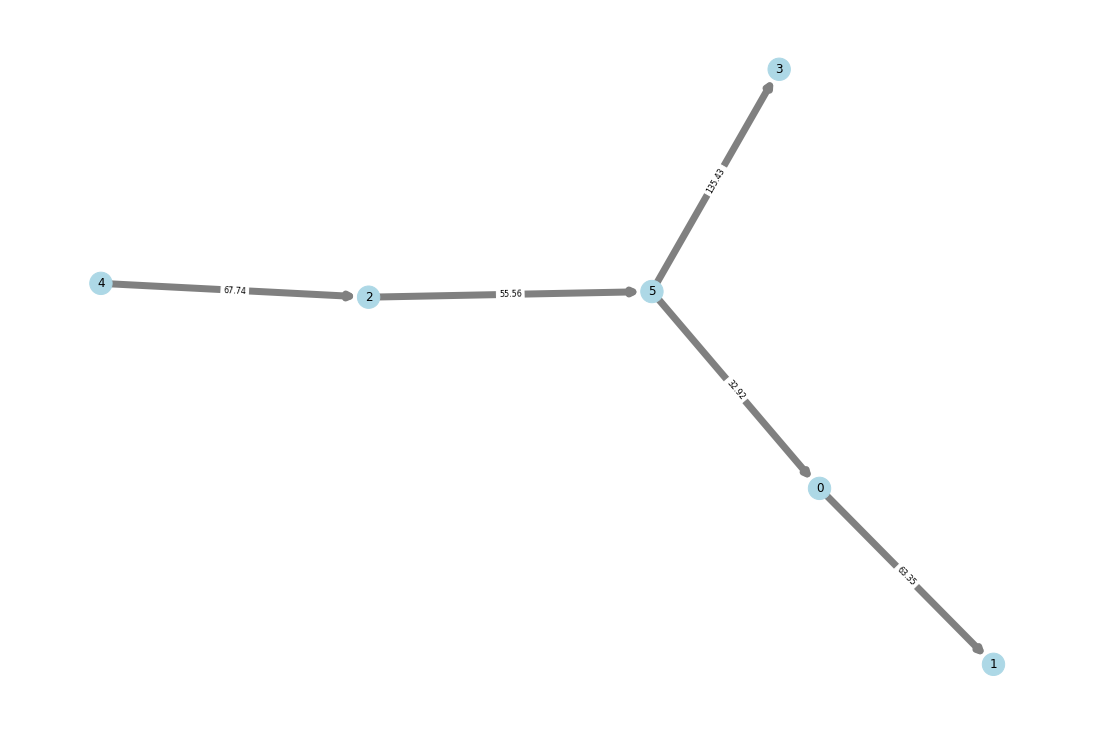

In [26]:
# Round decimal places
for (u,v,d) in G.edges(data=True):
	d['length'] = round(d['length'],2)

plt.figure(figsize=(15,10))
colors = ['lightblue' for node in G.nodes()]
pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
nx.draw(G, pos, with_labels = True, node_color = colors, edge_color = 'gray' , node_size=500, width = 7)  
edge_labels = dict([((u, v,), d['length']) for (u, v, d) in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, label_pos = 0.5, font_size = 8) 
plt.show()

In [27]:
# Normalization
norm = []
for (u,v,d) in G.edges(data=True):
	norm.append(d['length'])
  
norm = np.array(norm)
for (u,v,d) in G.edges(data=True):
  d['length'] = (d['length'] - norm.min()) / (norm.max() - norm.min())
  
# Computing the length matrix from the random graph
n = len(G)
w = np.zeros([n,n])
for (u,v,d) in G.edges(data=True):
  w[u,v] = round(d['length'],2)
  w[v,u] = round(d['length'],2)
print(w)

[[0.   0.3  0.   0.   0.   0.  ]
 [0.3  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.34 0.22]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.34 0.   0.   0.  ]
 [0.   0.   0.22 1.   0.   0.  ]]


In [0]:
# Mapping to the Ising problem
qubitOp, offset = max_cut.get_max_cut_qubitops(w)
algo_input = EnergyInput(qubitOp)

energy: -0.6993750000000001
time: 110.26506161689758
max-cut objective: -1.629375
solution: [1 0 1 0 0 1]
solution objective: 1.6400000000000001


{(0, 1): Text(-0.7740565241255344, -0.014460517949348516, '0.3'),
 (2, 5): Text(0.12001025485035556, -0.02067079126742952, '0.22'),
 (4, 2): Text(0.22332293055114794, -0.01649806465173305, '0.34'),
 (5, 0): Text(-0.3405595208713741, 0.07766345803161076, '0.0'),
 (5, 3): Text(0.5507335935743864, 0.03095858260108152, '1.0')}

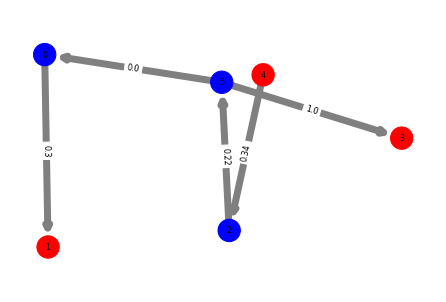

In [35]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

"""declarative approach, update the param from the previous cell.
params['backend']['provider'] = 'qiskit.BasicAer'
params['backend']['name'] = 'qasm_simulator'
params['backend']['shots'] = 1024
result = run_algorithm(params, algo_input)
"""

x = max_cut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, node_color = colors, edge_color = 'gray' ,width = 7, node_size=500, font_size = 8, font_color='black')  
edge_labels = dict([((u, v,), round(d['length'],2)) for (u, v, d) in G.edges(data = True)])
nx.draw_networkx_edge_labels(G, pos, with_labels = False, edge_labels = edge_labels, label_pos = 0.5, font_size = 8) 


In [36]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright